# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

In [1]:
# Import all required packages, this way we make sure everything is installed

# standard packages
import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
torch.manual_seed(42)
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from torchvision import datasets, transforms, models

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
# Load the images from a folder where training and test images are in separate sub-folders
images_root = "landmark_images"
train_folder = os.path.join(images_root, "train")
test_folder = os.path.join(images_root, "test")

# use mean and std from imagenet
image_mean=[0.485, 0.456, 0.406]
image_std=[0.229, 0.224, 0.225]

to_tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])

# applied only to training set
train_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # the next two transforms crop off the black bars from the random rotation
    transforms.CenterCrop(256),
    # pick a small part from the center for spatial variation
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1), ratio=(3/4, 4/3)),
    to_tensor_transform,
]);

# applied to testing and validation sets
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    # takes crops of the 4 corners plus center
    # we will later average the accuracy for all 5 images during testing to get a better sense of network quality
#     transforms.FiveCrop(224),
#     transforms.Lambda(lambda tensors: torch.stack([to_tensor_transform(t) for t in tensors]))
    transforms.CenterCrop(224),
    to_tensor_transform,
]);

# transforms will be applied to the training set after splitting off the validation set
dataset_train = datasets.ImageFolder(train_folder, transform=train_transforms)
dataset_valid = datasets.ImageFolder(train_folder, transform=test_transforms)
print(f"Images in training set: {len(dataset_train)}")
dataset_test = datasets.ImageFolder(test_folder, transform=test_transforms)
print(f"Images in test set: {len(dataset_test)}")

train_classes = dataset_train.classes
test_classes = dataset_test.classes

# reduce number of classes for testing so we don't run out of memory
num_train_classes = None
if num_train_classes is not None:
    idx = [i for i in range(len(dataset_train)) if dataset_train.imgs[i][1] < num_train_classes]
    # build the appropriate subset
    train_classes = train_classes[:num_train_classes]
    dataset_train = torch.utils.data.Subset(dataset_train, idx)
    idx = [i for i in range(len(dataset_test)) if dataset_test.imgs[i][1] < num_train_classes]
    # build the appropriate subset
    test_classes = test_classes[:num_train_classes]
    dataset_test = torch.utils.data.Subset(dataset_test, idx)

# split the training data into training and validation set
# keeping it small since this removes images from training
valid_size = 0.05
# set this to a lower value to use fewer images (to combat out of memory errors)
train_size = 1 - valid_size

# get all indices and split them according to valid_size
train_indices = [idx for idx in range(len(dataset_train))]
np.random.shuffle(train_indices)
train_split_index = int(train_size * len(train_indices))
valid_split_index = int((train_size + valid_size) * len(train_indices))

# create random samplers for  the indices in each subset
train_set = torch.utils.data.Subset(dataset_train, train_indices[:train_split_index])
valid_set = torch.utils.data.Subset(dataset_valid, train_indices[train_split_index:valid_split_index])
print(f"Images in training sampler: {len(train_set)}")
print(f"Images in validation sampler: {len(valid_set)}")
print(f"Images in test sampler: {len(dataset_test)}")

loaders_scratch = {
    'train': torch.utils.data.DataLoader(
        train_set,
        batch_size=32,
        pin_memory=True,
        num_workers=3,
    ),
    'valid': torch.utils.data.DataLoader(
        valid_set,
        batch_size=32,
        pin_memory=True,
        num_workers=3,
    ),
    'test': torch.utils.data.DataLoader(
        dataset_test,
        batch_size=32,
        shuffle=True,
        pin_memory=True,
        num_workers=3,
    ),
}

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes_scratch = {
    'train': train_classes,
    'valid': train_classes,
    'test': test_classes,
}

Images in training set: 4996
Images in test set: 1250
Images in training sampler: 4746
Images in validation sampler: 250
Images in test sampler: 1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

1. Training datasets
  * I am first resizing the image to 300 pixels along the smallest dimension. This will reduce the size and give the following transforms a consistent size to work off of and make them faster
  * Images are then flipped horizontally with a 50% chance to vary the network input since there is not a huge amount of data
  * Next I am applying random rotation (+-10 degrees) and scaling (+-10%). Images are scaled down at most by a factor of 0.9 so they will never be smaller than the following random crop
  * the crop sizes are chosen in such a way that even at the highest rotation of 10 degrees I don't get lack borders around the image. this should give the network more natural looking images with rotation to learn from
2. Validation and test datasets
  * images are resized to 256 pixels and then a center crop of 224 pixels is used
  * the only transform is a horizontal random flip which will allow me to get a better sense of network generalization and increase the number of available images for testing
3. the final crop size of 224 pixels is used so that after 5 Maxpool layers each halving the image we arrive at a 7x7 image which still has a centerpoint

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

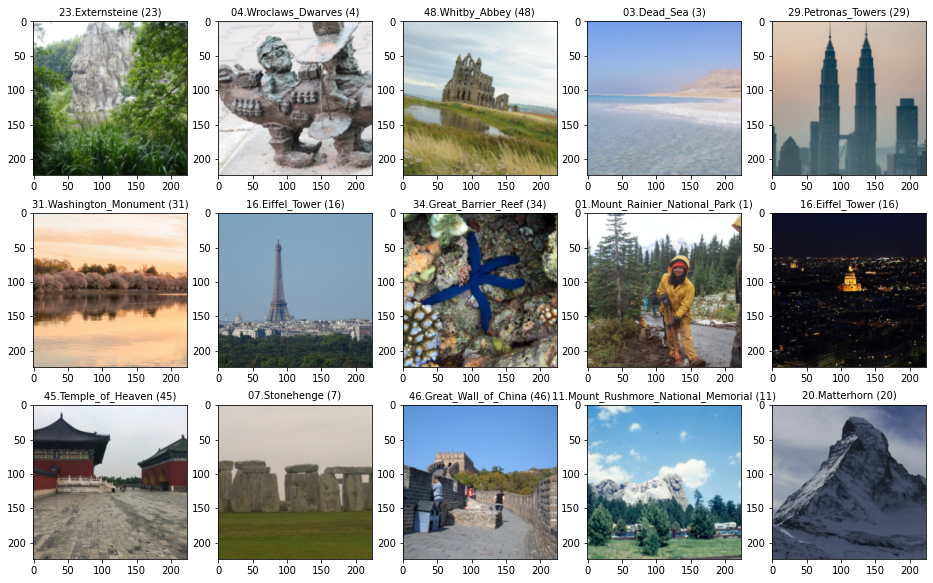

In [3]:
def display_tensor_image(image, ax, norm=np.array([image_mean, image_std])):
    img = np.array(image)
    # for the test set we get a 5-tuple of images
    if len(img.shape) == 4:
        # take only the first image to visualize
        img = img[0,:]
    img = img.transpose(1, 2, 0)
    if norm is not None:
        img = (img * norm[1] + norm[0]).clip(0, 1)
    ax.imshow(img)

# visualize 5 images from each dataset
fig, axes = plt.subplots(3, 5, figsize=(16, 10))
for row_num, row_axes in enumerate(axes):
    # Get one of the 3 data loaders
    name, loader = list(loaders_scratch.items())[row_num]
    images, labels = next(iter(loader))
    # get the classes for this loader from the prepared dict
    classes = classes_scratch[name]

    for col_num, ax in enumerate(row_axes):
        ax.set_title(f"{classes[labels[col_num]]} ({labels[col_num]})", fontsize=10)
        display_tensor_image(images[col_num], ax)

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
criterion_scratch = nn.NLLLoss()

def get_optimizer_scratch(model):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
    return optimizer, scheduler

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, output_classes=len(train_classes)):
        super(Net, self).__init__()
        
        self.output_classes = output_classes

        # some baseline constants for easier tweaking
        # start number of filters, will be doubled after each maxpool
        num_filters = 32
        
        # helper to get a repeated block of 2 convolution layers and a maxpool
        get_conv_block = lambda fromM, toM, useNorm=False: filter(
            lambda op: op is not None, [
                # bias has no effect if batch norm is applied directly afterwards
                nn.Conv2d(int(num_filters * fromM), num_filters * toM, 3, padding=1, bias=(not useNorm)),
                nn.BatchNorm2d(num_features=num_filters * toM) if useNorm else None,
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            ])

        # using vgg as inspiration:
        self.features = nn.Sequential(
            # input 224x224
            nn.Conv2d(3, num_filters, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input 112x112
            *get_conv_block(1, 2),
            # input 56x56
            *get_conv_block(2, 4),
            # input 28x28
            *get_conv_block(4, 8),
            # input 14x14
            *get_conv_block(8, 8, True),
        )
        
        self.classifier = nn.Sequential(
            # input 7x7
            nn.Flatten(),
            nn.Linear(7 * 7 * num_filters * 8, 4096),
            nn.BatchNorm1d(num_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # memory constraints on the GPU don't allow me to add another linear layer
            nn.Linear(4096, output_classes),
            nn.LogSoftmax(dim=1),
        )
        
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)
    
    def save(self, path):
        checkpoint = {
            "output_classes": self.output_classes,
            "state_dict": self.state_dict(),
        }
        torch.save(checkpoint, path)

    def load(path):
        checkpoint = torch.load(path)
        model = Net(output_classes=checkpoint["output_classes"])
        model.load_state_dict(checkpoint["state_dict"])
        return model

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
I used the VGG network as inspiration although I had to implement the smallest possible, VGG11. The GPU I use for training only has 4GB of ram which was limiting the network size and number of layers.

The input image size of 224x224 needs to be reduced while increasing the number of filters. Through halving we  can go down to 7x7 with 5 Maxpool layers so I have chosen this number.

Within each block I am sticking to a repeatable architecture of a Conv2d layer with 3x3 kernel and 1px padding. Only the last Conv2d layer has a batch norm applied before the ReLU activation.

The number of filters doubles after each block with 256 filters after the  last layer.

The final classification is done by a 2 linear layers, learning the mapping between the 7x7x256 convolution output and the 50 target classes. Batch normalization after the first layer is used to try and improve the stability and learning rate of the classification network.

A softmax layer as the last step maps the detected probabilities to the one-hot encoded output classes.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    accuracy_max = 0
    
    optimizer, scheduler = optimizer
    
    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda', non_blocking=True), target.to('cuda', non_blocking=True)

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()

            output = model.forward(data)

            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        train_loss /= len(loaders['train'])

        ######################    
        # validate the model #
        ######################
        valid_total = 0
        valid_correct = 0
        with torch.no_grad():
            # set the model to evaluation mode
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.to('cuda', non_blocking=True), target.to('cuda', non_blocking=True)

                output = model.forward(data)
                loss = criterion(output, target)
                valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

                # calculate accuracy
                # convert output probabilities to predicted class
                pred = torch.exp(output).data.max(1, keepdim=True)[1]
                # compare predictions to true label
                valid_total += data.size(0)
                valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

        valid_loss /= len(loaders['valid'])
        accuracy = valid_correct / valid_total

        lr = None
        if scheduler is not None:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        # print training/validation statistics 
        print(" ".join([
            f"Epoch: {str(epoch).zfill(2)}",
            f"LR: {round(lr, 4)}" if lr is not None else "",
            f"Training Loss: {round(train_loss, 6)}",
            f"Validation Loss: {round(valid_loss, 6)}",
            f"Accuracy: {round(100 * accuracy, 1)}%",
        ]))

        # if the validation loss has decreased, save the model at the filepath stored in save_path
#         if valid_loss < valid_loss_min:
        if accuracy > accuracy_max:
            print("Accuracy increased, saving model")
            # use the model's own save function if it exists
            save = getattr(model, "save", None)
            if callable(save):
                save(save_path)
            else:
                torch.save(model.state_dict(), save_path)
#             valid_loss_min = valid_loss
            accuracy_max = accuracy
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    """Initialize weights using a normal distribution"""
    reset_parameters = getattr(m, 'reset_parameters', None)
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # std dev is 1 / n
        std = 1.0 / np.sqrt(m.in_features)
        m.weight.data.normal_(0, std)
        m.bias.data.fill_(0)
    elif callable(reset_parameters):
        m.reset_parameters()


#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(
    20,
    loaders_scratch,
    model_scratch,
    get_optimizer_scratch(model_scratch),
    criterion_scratch,
    use_cuda,
    'ignore.pt',
)

Epoch: 01 LR: 0.01 Training Loss: 0.061092 Validation Loss: 1.801314 Accuracy: 3.2%
Accuracy increased, saving model
Epoch: 02 LR: 0.01 Training Loss: 0.031041 Validation Loss: 0.476655 Accuracy: 9.2%
Accuracy increased, saving model
Epoch: 03 LR: 0.01 Training Loss: 0.024726 Validation Loss: 0.491876 Accuracy: 11.6%
Accuracy increased, saving model
Epoch: 04 LR: 0.01 Training Loss: 0.022297 Validation Loss: 0.508992 Accuracy: 14.8%
Accuracy increased, saving model
Epoch: 05 LR: 0.01 Training Loss: 0.020782 Validation Loss: 0.437183 Accuracy: 18.0%
Accuracy increased, saving model
Epoch: 06 LR: 0.01 Training Loss: 0.019301 Validation Loss: 0.455529 Accuracy: 20.4%
Accuracy increased, saving model
Epoch: 07 LR: 0.01 Training Loss: 0.017976 Validation Loss: 0.464502 Accuracy: 22.0%
Accuracy increased, saving model
Epoch: 08 LR: 0.01 Training Loss: 0.016948 Validation Loss: 0.513316 Accuracy: 18.8%
Epoch: 09 LR: 0.01 Training Loss: 0.015639 Validation Loss: 0.415097 Accuracy: 25.2%
Accura

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(
    num_epochs,
    loaders_scratch,
    model_scratch,
    get_optimizer_scratch(model_scratch), 
    criterion_scratch,
    use_cuda,
    'model_scratch.pt',
)

Epoch: 01 LR: 0.01 Training Loss: 0.060782 Validation Loss: 0.75409 Accuracy: 2.0%
Accuracy increased, saving model
Epoch: 02 LR: 0.01 Training Loss: 0.02976 Validation Loss: 0.474305 Accuracy: 10.8%
Accuracy increased, saving model
Epoch: 03 LR: 0.01 Training Loss: 0.02452 Validation Loss: 0.445893 Accuracy: 12.8%
Accuracy increased, saving model
Epoch: 04 LR: 0.01 Training Loss: 0.022645 Validation Loss: 0.429291 Accuracy: 15.2%
Accuracy increased, saving model
Epoch: 05 LR: 0.01 Training Loss: 0.021664 Validation Loss: 0.438103 Accuracy: 16.0%
Accuracy increased, saving model
Epoch: 06 LR: 0.01 Training Loss: 0.020641 Validation Loss: 0.511652 Accuracy: 12.0%
Epoch: 07 LR: 0.01 Training Loss: 0.019484 Validation Loss: 0.525746 Accuracy: 14.4%
Epoch: 08 LR: 0.01 Training Loss: 0.018544 Validation Loss: 0.557949 Accuracy: 18.8%
Accuracy increased, saving model
Epoch: 09 LR: 0.01 Training Loss: 0.017762 Validation Loss: 0.44124 Accuracy: 26.4%
Accuracy increased, saving model
Epoch: 10

Epoch: 91 LR: 0.0006 Training Loss: 0.000129 Validation Loss: 0.590371 Accuracy: 39.6%
Epoch: 92 LR: 0.0006 Training Loss: 0.000104 Validation Loss: 0.572197 Accuracy: 41.6%
Epoch: 93 LR: 0.0006 Training Loss: 0.000115 Validation Loss: 0.58335 Accuracy: 42.4%
Epoch: 94 LR: 0.0006 Training Loss: 0.000109 Validation Loss: 0.583494 Accuracy: 42.8%
Epoch: 95 LR: 0.0006 Training Loss: 0.0001 Validation Loss: 0.586494 Accuracy: 39.6%
Epoch: 96 LR: 0.0006 Training Loss: 8.8e-05 Validation Loss: 0.584852 Accuracy: 41.6%
Epoch: 97 LR: 0.0006 Training Loss: 8.8e-05 Validation Loss: 0.592673 Accuracy: 42.8%
Epoch: 98 LR: 0.0006 Training Loss: 8.3e-05 Validation Loss: 0.572898 Accuracy: 40.4%
Epoch: 99 LR: 0.0006 Training Loss: 9.2e-05 Validation Loss: 0.581918 Accuracy: 38.8%
Epoch: 100 LR: 0.0003 Training Loss: 8.5e-05 Validation Loss: 0.583887 Accuracy: 41.6%


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    with torch.no_grad():
        # set the module to evaluation mode
        model.eval()

        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda', non_blocking=True), target.to('cuda', non_blocking=True)

            # the test data creates multiple crops of each image
            # we forward each through the model and average the loss
    #         for crops in data:
            if len(data.shape) > 4:
                data = data.reshape((-1,3,224,224))
                target = target.repeat(5)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
            # convert output probabilities to predicted class
            pred = torch.exp(output).data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

        print("\n".join([
            f"Test Loss: {round(test_loss, 6)}",
            f"Test Accuracy: {int(100. * correct / total)}% ({int(correct)}/{int(total)})",
        ]))

In [11]:
# load the model that got the best validation accuracy
# model_scratch.load_state_dict(torch.load('model_scratch.pt'))
# model_scratch = Net.load('ignore.pt')
model_scratch = Net.load('model_scratch.pt')
if use_cuda:
    model_scratch.cuda()

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.558631
Test Accuracy: 38% (484/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
# use_cuda = False
use_cuda

True

In [13]:
# Load the images from a folder where training and test images are in separate sub-folders
images_root = "landmark_images"
train_folder = os.path.join(images_root, "train")
test_folder = os.path.join(images_root, "test")

# use mean and std from imagenet
image_mean=[0.485, 0.456, 0.406]
image_std=[0.229, 0.224, 0.225]

to_tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])

# applied to training and validation set, fixed transforms making images smaller and other transforms faster
pre_transforms = transforms.Compose([
    transforms.Resize(300),
]);

# applied only to training set
train_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # the next two transforms crop off the black bars from the random rotation
    transforms.CenterCrop(256),
    # pick a small part from the center for spatial variation
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1), ratio=(3/4, 4/3)),
    to_tensor_transform,
]);

# applied to testing and validation sets
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    # takes crops of the 4 corners plus center
    # we will later average the accuracy for all 5 images during testing to get a better sense of network quality
#     transforms.FiveCrop(224),
#     transforms.Lambda(lambda tensors: torch.stack([to_tensor_transform(t) for t in tensors]))
    transforms.CenterCrop(224),
    to_tensor_transform,
]);

# transforms will be applied to the training set after splitting off the validation set
dataset_train = datasets.ImageFolder(train_folder, transform=train_transforms)
dataset_valid = datasets.ImageFolder(train_folder, transform=test_transforms)
print(f"Images in training set: {len(dataset_train)}")
dataset_test = datasets.ImageFolder(test_folder, transform=test_transforms)
print(f"Images in test set: {len(dataset_test)}")

train_classes = dataset_train.classes
test_classes = dataset_test.classes

# reduce number of classes for testing so we don't run out of memory
num_train_classes = None
if num_train_classes is not None:
    idx = [i for i in range(len(dataset_train)) if dataset_train.imgs[i][1] < num_train_classes]
    # build the appropriate subset
    train_classes = train_classes[:num_train_classes]
    dataset_train = torch.utils.data.Subset(dataset_train, idx)
    idx = [i for i in range(len(dataset_test)) if dataset_test.imgs[i][1] < num_train_classes]
    # build the appropriate subset
    test_classes = test_classes[:num_train_classes]
    dataset_test = torch.utils.data.Subset(dataset_test, idx)

# split the training data into training and validation set
# keeping it small since this removes images from training
valid_size = 0.05
# set this to a lower value to use fewer images (to combat out of memory errors)
train_size = 1 - valid_size

# get all indices and split them according to valid_size
# also shuffle  randomly so the validation set is not just the last few classes
train_indices = [idx for idx in range(len(dataset_train))]
np.random.shuffle(train_indices)
train_split_index = int(train_size * len(train_indices))
valid_split_index = int((train_size + valid_size) * len(train_indices))

# create random samplers for  the indices in each subset
train_set = torch.utils.data.Subset(dataset_train, train_indices[:train_split_index])
valid_set = torch.utils.data.Subset(dataset_valid, train_indices[train_split_index:valid_split_index])
print(f"Images in training sampler: {len(train_sampler)}")
print(f"Images in validation sampler: {len(valid_sampler)}")
print(f"Images in test sampler: {len(dataset_test)}")

loaders_transfer = {
    'train': torch.utils.data.DataLoader(
        train_set,
        batch_size=24,
        pin_memory=True,
        num_workers=3,
    ),
    'valid': torch.utils.data.DataLoader(
        valid_set,
        batch_size=24,
        pin_memory=True,
        num_workers=3,
    ),
    'test': torch.utils.data.DataLoader(
        dataset_test,
        batch_size=24,
        shuffle=True,
        pin_memory=True,
        num_workers=3,
    ),
}

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes_transfer = {
    'train': train_classes,
    'valid': train_classes,
    'test': test_classes,
}

Images in training set: 4996
Images in test set: 1250
Images in training sampler: 4746
Images in validation sampler: 250
Images in test sampler: 1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [15]:
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
#     optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.005)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    return optimizer, scheduler

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
# using vgg11 as feature detector
model_transfer = models.vgg16(pretrained=True)
# AlexNet should be smaller
# model_transfer = models.alexnet(pretrained=True)
# print(model_transfer)

# layer 6 in the classifier is the last layer
# print(model_transfer.classifier[6].in_features) 
# print(model_transfer.classifier[6].out_features) 
# replace it with our own layer mapping to the target classes and set the classifier to be trained again
model_transfer.classifier[6] = nn.Linear(4096, len(train_classes))

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
for layer in model_transfer.classifier:
    reset_parameters = getattr(layer, 'reset_parameters', None)
    classname = layer.__class__.__name__
    if classname.find('Linear') != -1:
        # std dev is 1 / n
        std = 1.0 / np.sqrt(layer.in_features)
        layer.weight.data.normal_(0, std)
        layer.bias.data.fill_(0)
    elif callable(reset_parameters):
        layer.reset_parameters()
for param in model_transfer.classifier.parameters():
    param.requires_grad = True

print("Classifier:", model_transfer.classifier)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Classifier: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=50, bias=True)
)


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

I chose VGG16 as a feature detector network since it is still reasonably sized and has great performance on image classification tasks.

Gradient calculation on the feature detector layer is then disabled since we want to use the pre-trained feature detector. I replaced the last linear layer in the classifier with one that outputs the correct number of training classes (50) and then reinitialized all the weights with a normal distribution. Without this reinitialization step the network will not learn and achieve very bad accuracy.

I then set the batch size to 24 because this still allows me to train the network on a 4GB GPU (it runs out of memory with a batch size of 32).


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# train the model
model_transfer = train(
    50,
    loaders_transfer,
    model_transfer,
    get_optimizer_transfer(model_transfer), 
    criterion_transfer,
    use_cuda,
    'model_transfer.pt',
)

Epoch: 01 LR: 0.005 Training Loss: 0.016494 Validation Loss: 0.17559 Accuracy: 55.6%
Accuracy increased, saving model
Epoch: 02 LR: 0.005 Training Loss: 0.010599 Validation Loss: 0.130661 Accuracy: 62.8%
Accuracy increased, saving model
Epoch: 03 LR: 0.005 Training Loss: 0.008086 Validation Loss: 0.113138 Accuracy: 66.0%
Accuracy increased, saving model
Epoch: 04 LR: 0.005 Training Loss: 0.006585 Validation Loss: 0.100412 Accuracy: 71.2%
Accuracy increased, saving model
Epoch: 05 LR: 0.005 Training Loss: 0.005483 Validation Loss: 0.098528 Accuracy: 70.4%
Epoch: 06 LR: 0.005 Training Loss: 0.004781 Validation Loss: 0.094689 Accuracy: 71.6%
Accuracy increased, saving model
Epoch: 07 LR: 0.005 Training Loss: 0.004126 Validation Loss: 0.094902 Accuracy: 72.4%
Accuracy increased, saving model
Epoch: 08 LR: 0.005 Training Loss: 0.003539 Validation Loss: 0.093466 Accuracy: 72.8%
Accuracy increased, saving model
Epoch: 09 LR: 0.005 Training Loss: 0.003115 Validation Loss: 0.096293 Accuracy: 72

In [15]:
# torch.save(model_transfer.state_dict(), 'model_transfer.pt')

In [18]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
if use_cuda:
    model_transfer.cuda()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.96451
Test Accuracy: 78% (978/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

